## **Lab 11: Single-View Metrology** 

Previously, we have implemented an approach for estimating vanishing points from Section 4 of http://slazebni.cs.illinois.edu/spring19/3dscene_book_svg.pdf. 

In this lab, we will build on what we have done last week and use the computed vanishing points for an image to estimate the parameters of the camera such as focal length and rotation matrix as well as 

In [1]:
import numpy as np
import cv2
import itertools
from math import isclose
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def displayImage(img: np.array, window_name: str = "Display window") -> None:
    '''
        Display an image in a numpy array using cv2.
        Note: cv2 assumes images to be stored in HxWxC and BGR format
        if the images are in float, they are assumed to be in 0-1
        range.
        
        
        :param img: Image to display stored in a numpy array
        :param window_name: Name to display on the window
    '''
    
    # Run locally
    cv2.namedWindow(window_name, cv2.WINDOW_AUTOSIZE)
    cv2.imshow(window_name, img)
    # Wait for a key event infinitely
    cv2.waitKey(0)

    # Close all open windows  
    cv2.destroyAllWindows()  
    # For mac users, uncomment the following line
    cv2.waitKey(1)
    
    # Run in google colab
    # from google.colab.patches import cv2_imshow
    # cv2_imshow(img)

In [3]:
def detect_lines(image: np.array) -> np.array: 
    '''
        Detect lines in the given image.
        :param image: image stored in a numpy array
    '''
    # Convert to grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Blur image to reduce noise.
    image = cv2.GaussianBlur(image, (5, 5), 1)
    # Detect edges
    edges = cv2.Canny(image, 50, 150)
    # Detect lines
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, None, 50, 10)
    
    print(len(lines))
    return edges, lines

In [4]:
def process_lines(pts: np.array) -> np.array:
    '''
        Process line features.
        Represent lines as the following tuple
        (pt1, pt2, a, b, c, m, l, theta)
        where pt1, pt2 are endpoints in homogeneous coordinates, a, b, c are coefficient of line equation ax + by + c = 0, 
        m is the midpoint of the line segment, l is the length of line segment 
        theta is the angle between the line and x axis
        :param lines: lines stored in a numpy array
    '''
    
    # Points in homogeneous coordinates
    pt1 = np.concatenate((pts[:, 0, :2], np.ones((len(pts), 1))), axis=1)
    pt2 = np.concatenate((pts[:, 0, 2:], np.ones((len(pts), 1))), axis=1)
    # line equation (a, b, c) = pt1 x pt2
    line_eq = np.cross(pt1, pt2)
    # midpoint
    m = (pt1 + pt2) / 2
    # length of the line segment
    l = np.linalg.norm(np.stack((pts[:, 0, 0] - pts[:, 0, 2], pts[:, 0, 1] - pts[:, 0, 3]), axis=1), axis=1)
    # angle 
    theta = np.reshape([np.arctan(-a / b) if b != 0 else np.pi/2 for (a, b, c) in line_eq], (-1, 1))

    lines = np.concatenate((pt1, pt2, line_eq, m, l.reshape((-1, 1)), theta), axis=1)
    
#     lines = sorted(lines, key=lambda x : x[-2], reverse=True)[:20]
    
    return lines

In [5]:
def compute_candidate_vp(lines: np.array) -> np.array:
    '''
        Compute vanishing point candidates and their scores.
        :param lines: lines stored in a numpy array: (pt1, pt2, a, b, c, m, l, theta)
    '''
    
    sigma = 0.1 # scaling parameter
    vp_candidates = []
    for pair in itertools.combinations(lines,2):
        # candidate of vanishing point: intersection of two lines = line1 x line2
        vp = np.cross(pair[0][6:9], pair[1][6:9])
        vp = vp / vp[-1] if vp[-1] != 0 else vp
        assert isclose(np.dot(vp, pair[0][6:9]), 0, abs_tol=1e-09) and isclose(np.dot(vp, pair[1][6:9]), 0, abs_tol=1e-09) 
        score = 0
        for line in lines:
            # line from vp to the midpoint of line segment
            line_vp2mp = np.cross(line[9:12], vp)
            alpha = np.arctan(-line_vp2mp[0] / line_vp2mp[1]) if line_vp2mp[1] != 0 else np.pi / 2
            score += line[-2] * np.exp(-abs(alpha - line[-1]) / 2 / sigma**2)
        vp_candidates.append((vp, score))

    return vp_candidates


In [6]:
def choose_vp(vp_candidates: np.array) -> np.array:
    '''
        Choose the triplet of vanishing points candidates with the highest score 
        that also leads to reasonable camera parameters.
        :param vp_candidates: candidate vanishing points and scores
    '''
    max_score = 0
    final_K = []
    max_triplet = []
    
    vp_candidates = sorted(vp_candidates, key=lambda x : x[1], reverse=True)
    
    first_vp = vp_candidates[0]
    for pair in itertools.combinations(vp_candidates[1:],2):
        total_score = first_vp[1] + pair[0][1] + pair[1][1]
        K = estimate_K(first_vp[0], pair[0][0], pair[1][0])
        if len(K) > 0:
            if K[0][0] > 0 and image.shape[1] // 3 < K[0][-1] < image.shape[1] // 3 * 2\
                and image.shape[0] // 3 < K[1][-1] < image.shape[0] // 3 * 2:
                if total_score > max_score:
                    max_score = total_score
                    final_K = K
                    max_triplet = (first_vp, pair[0], pair[1])

#     for triplet in itertools.combinations(vp_candidates,3):
#         total_score = triplet[0][1] + triplet[1][1] + triplet[2][1]
#         K = estimate_K(triplet[0][0], triplet[1][0], triplet[2][0])
#         if len(K) > 0:
#             if K[0][0] > 0 and image.shape[1] // 3 < K[0][-1] < image.shape[1] // 3 * 2\
#                 and image.shape[0] // 3 < K[1][-1] < image.shape[0] // 3 * 2:
#                 if total_score > max_score:
#                     max_score = total_score
#                     final_K = K
#                     max_triplet = triplet
                    
    return final_K, max_triplet

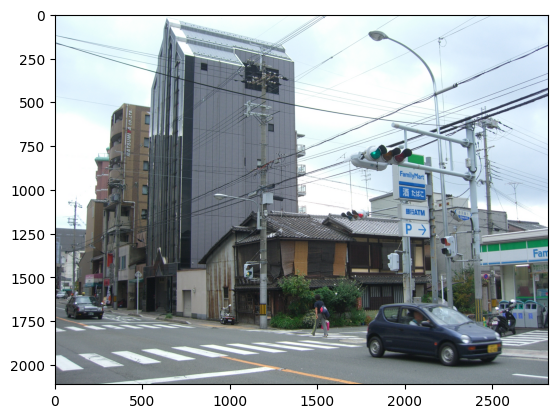

In [7]:
image = cv2.imread('kyoto_street.jpg')
plt.imshow(image[...,::-1])

For the given image, we provide the following 3 vanishing points in pixel coordinates with the top-left pixel set at (1, 1):

```
vp1 = [1.0946e+03 -2.0780e+04 1]
vp2 = [5.3031e+03 1.4922e+03 1]
vp3 = [-836.7876 1.6697e+03 1]
```

Given these vanishing points, compute the horizon. Recall that the horizon is a line passing through vanishing points of lines parallel to the ground plane. Thus, you will be using vp2 and vp3 in this case.


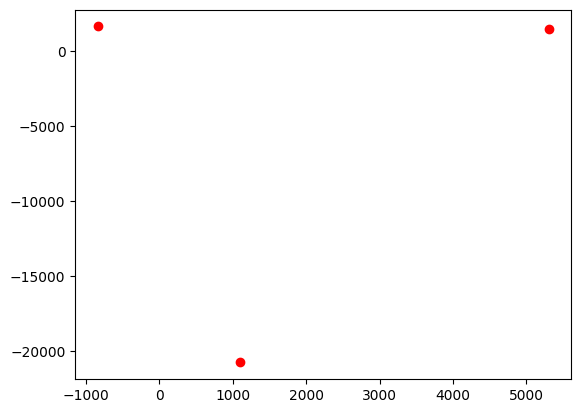

In [8]:
import numpy as np
import cv2
import itertools
from math import isclose
import matplotlib.pyplot as plt

vp1 = np.array([1.0946e+03, -2.0780e+04, 1])
vp2 = np.array([5.3031e+03, 1.4922e+03, 1])
vp3 = np.array([-836.7876, 1.6697e+03, 1])
all_vps = [vp1, vp2, vp3]

# plot
#((array([ 8.16733333e+03, -5.10408333e+05,  1.00000000e+00]), 3474.5574234925057), (array([528.16472652, 255.2016159 ,   1.        ]), 818.692561417757), (array([-1.81560911e+03,  2.18746679e+02,  1.00000000e+00]), 264.1701544684595))
'''for pt in all_vps:
    plt.plot(int(pt[0][0]), int(pt[0][1]), marker = 'o', color='red')
    print(pt[0][0],pt[0][1])
plt.show()'''

for pt in all_vps:
    plt.plot(int(pt[0]), int(pt[1]), marker = 'o', color='red')
plt.show()

In [9]:
def compute_horizon(first_vp, second_vp):
  """
  params:
  first_vp: array of size 3 which denotes the pixel coordinates of the first vanishing point
  second_vp: array of size 3 which denotes the pixel coordinates of the first vanishing point

  returns horizon line parameters a, b and c
  """
  return np.cross(first_vp, second_vp)

horizon = compute_horizon(vp2, vp3)
print('computed horizon: ', horizon)

computed horizon:  [-1.77500000e+02 -6.13988760e+03  1.01032405e+07]


Now, we will estimate the intrinsic parameters of the camera which includes the focal length and optical center. We assume that the camera has unit aspect ratio and zero skew. Recall that we can formulate 3 constraints based on the property of orthogonality. For each pairwise combination of the set of 3 vanishing points, we can set up the following constraint for the i-th and j-th vanishing point as such: $v_i^T K^{-T}K^{-1}v_j = 0$. 

Steps:
1. we set $ω = K^{-T}K^{-1}$.
2. we stack the constraints for all 3 pairs of vanishing points to form the following equation: $Aω = 0$, where $A$ is a 3x4 matrix.
3. To compute $K$, we first perform Cholesky factorization of $\omega$ before inverting it.
 


In [25]:
def estimate_K(vp1: np.array, vp2: np.array, vp3: np.array) -> np.array:
    '''
        Estimate intrinsic camera parameters given three vanishing points
        See Multiple View Geometry in Computer Vision (pag. 226) 
        
        :param vp1: first vanishing point
        :param vp2: second vanishing point
        :param vp3: third vanishing point
    '''
    try:
        A = []
        for (p1, p2) in itertools.combinations([vp1, vp2, vp3], 2):
            A.append([p1[0]*p2[0]+p1[1]*p2[1], p1[0]*p2[2]+p1[2]*p2[0], p1[1]*p2[2]+p1[2]*p2[1], p1[2]*p2[2]])
        u, s, v = np.linalg.svd(A, full_matrices=True)
        w1, w2, w3, w4 = v[-1,:]
        
        # form the omega matrix
        w = np.array([
            [w1, 0,  w2],
            [0,  w1, w3],
            [w2, w3, w4]
        ])
        # w = (KK^T)^-1    
        # K can be obtained by Cholesky factorization
        w_inv = np.linalg.inv(w)
        K_transpose_inv = np.linalg.cholesky(w_inv)
        K = K_transpose_inv.T
        K = K / K[-1, -1]
    except:
        return []
    
    return K

In [28]:
K = estimate_K(vp1, vp2, vp3)
print(K)

[[4.22679863e+03 7.20977099e+02 6.08540544e-01]
 [0.00000000e+00 3.87100705e+03 3.41821826e-01]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [ ]:
K = estimate_K(vp1, vp2, vp3)
print(K)

[[3.00364544e+03 0.00000000e+00 1.72958649e+03]
 [0.00000000e+00 3.00364544e+03 1.18476428e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


After estimating the intrinsic parameters of the camera, we can use the estimated matrix $K$ to compute the predicted extrinsic parameters of the camera which includes the rotation and translation matrices. In this lab, we assume that we are only estimating the rotation parameters matrix. Recall that the rotation matrix has 9 elements and can the following form: 
$\begin{matrix}
r_{11} & r_{12} & r_{13}\\
r_{21} & r_{22} & r_{23}\\
r_{31} & r_{32} & r_{33}\\
\end{matrix}$

We can compute each row $r_i = K^{-1}v_i$.

In [29]:
def estimate_R(K: np.array, vp1: np.array, vp2: np.array, vp3: np.array) -> np.array:
    '''
        Estimate extrinsic camera parameters given three vanishing points and estimated K
        
        :param vp1: first vanishing point
        :param vp1: first vanishing point
        :param vp2: second vanishing point
        :param vp3: third vanishing point
    '''
    K_inv = np.linalg.inv(K)
    R = []
    for curr_vp in [vp2, vp3, vp1]:
        curr_col = K_inv @ curr_vp # compute current row
        curr_mag = np.linalg.norm(curr_col)  # compute norm of the current row

        # normalize with curr_mag
        curr_col = curr_col / curr_mag 
        R.append(curr_col)

    R = np.stack(R)
    
    return np.transpose(R)

In [30]:
R = estimate_R(K, vp1, vp2, vp3)
print(R)

[[ 0.7427305  -0.24204827  0.21027788]
 [ 0.24079204  0.38421833 -0.96110814]
 [ 0.62479644  0.89094832  0.1790373 ]]


In [ ]:
R = estimate_R(K, vp1, vp2, vp3)
print(R)

[[-0.02863101  0.76385029 -0.64475809]
 [-0.9903729   0.0657154   0.1218319 ]
 [ 0.13543187  0.64203911  0.75461513]]


We will use the following image to predict the height of several objects. Estimate the heights of the tractor and the building (in feet). Our reference point is the street sign that we can assume to be 5 feet 6 inches. 

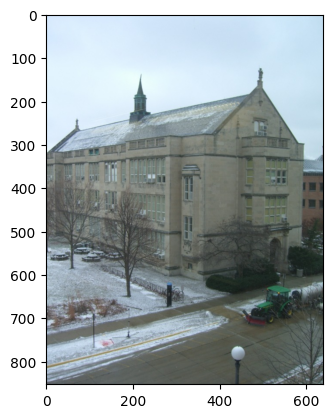

In [32]:
image = cv2.imread('street.jpg')
plt.imshow(image[...,::-1])

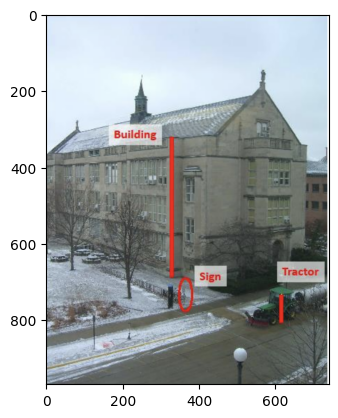

In [ ]:
image = cv2.imread('object_interest_image.png')
plt.imshow(image[...,::-1])

For this part, we will rely on precomputed vanishing points and their scores which are provided below.

In [33]:
vpts = ((np.array([1.723440e+03, 3.703575e+02, 1.000000e+00]), 1668.7517608400722), (np.array([355.22736697, 689.59364202, 1.]), 560.9237265729347), (np.array([287.55697959, 221.46726564, 1.]), 371.19172287226417))
print(vpts)

"""
coords = {'Sign': np.array([[313.73024892, 313.73024892], [618.94047619, 666.25243506], [1., 1.]]),
         'Building': np.array([[286.03544372, 288.34334416], [280.83306277, 600.47727273], [1., 1.]]),
         'Tractor': np.array([[545.67424242, 543.36634199], [643.17343074, 702.02489177], [1., 1.]])}
"""


((array([1.723440e+03, 3.703575e+02, 1.000000e+00]), 1668.7517608400722), (array([355.22736697, 689.59364202,   1.        ]), 560.9237265729347), (array([287.55697959, 221.46726564,   1.        ]), 371.19172287226417))


"\ncoords = {'Sign': np.array([[313.73024892, 313.73024892], [618.94047619, 666.25243506], [1., 1.]]),\n         'Building': np.array([[286.03544372, 288.34334416], [280.83306277, 600.47727273], [1., 1.]]),\n         'Tractor': np.array([[545.67424242, 543.36634199], [643.17343074, 702.02489177], [1., 1.]])}\n"

In [34]:
def get_top_and_bottom_coordinates(im, obj):
    """
    For a specific object, prompts user to record the top coordinate and the bottom coordinate in the image.
    Inputs:
        im: np.ndarray of shape (height, width, 3)
        obj: string, object name
    Returns:
        coord: np.ndarray of shape (3, 2)
            where coord[:, 0] is the homogeneous coordinate of the top of the object and coord[:, 1] is the homogeneous
            coordinate of the bottom
    """
    plt.figure()
    plt.imshow(im)

    print('Click on the top coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x1, y1 = clicked[0]
    # Uncomment this line to enable a vertical line to help align the two coordinates
    # plt.plot([x1, x1], [0, im.shape[0]], 'b')
    print('Click on the bottom coordinate of %s' % obj)
    clicked = plt.ginput(1, timeout=0, show_clicks=True)
    x2, y2 = clicked[0]
    
    return np.array([[x1, x2], [y1, y2], [1, 1]])

In [ ]:
%matplotlib tk
def estimate_height(obj_to_est, reference_object, reference_height, vpts):
    """
    Estimates height for a specific object using the recorded coordinates.
    """
    # <YOUR IMPLEMENTATION>
    # lets get everything in the terms used in Lecture 20
    
    t0, b0  = reference_object[:, 0], reference_object[:, 1] 
    r, b = obj_to_est[:, 0], obj_to_est[:, 1]

    vx, vy, vz = vpts[0][0], vpts[1][0], vpts[2][0]
    v = NotImplemented
    t = NotImplemented

    # let's ensure t is in homogenous coordinates
    t = t / t[-1]
        
    image_cross_ratio = NotImplemented
    return NotImplemented

# Record image coordinates for each object and store in map
im = np.asarray(Image.open('street.jpg'))
objects = ('Sign', 'Building', 'Tractor')

# <YOUR IMPLEMENTATION> Estimate heights
# Get pixel coordinates of the three objects, stored in a dictionary 'coords'
coords = dict()
coords=NotImplemented

for height in [66]:
  for obj in objects[1:]:
    ft = height // 12
    inches = height % 12
    print('Estimating height of %s at height %i ft %i inches' % (obj, ft, inches))
    pred_height = estimate_height(coords[obj], coords['Sign'], height, vpts)
    ft = pred_height // 12
    inches = pred_height % 12
    print('predicted height: %i ft %i inches' % (ft, inches))